# Take vsearch sintax output and plot taxonomic assignment confidence levels

### SSU rRNA reads were generated from (a) PhyloFlash on unassembled Illumina reads, (b) Illumina-SPAdes, PacBio-metaFlye, and Illumina-PacBio-hybridSPAdes contigs run against HMMs in anvi'o. 

### Extracted 18S rRNA reads were run against a sintax-formatted PR2 database using vsearch v2.21.1_linux_x86_64 with the following command:

vsearch --sintax {assembly}-18S-hmm-hits.fa --db /work/hpc/users/nvp29/databases/PR2/pr2_version_4.14.0_SSU_UTAX.fasta --tabbedout ../18S-PR2-vsearch-out/$n'_hybrid-18S-sintax-PR2-out.tsv

### Extracted 16S rRNA reads were run against a sintax-formatted SILVA 138.1 database using vsearch v2.21.1_linux_x86_64 with the following command: 
vsearch --sintax {assembly}-16S-hmm-hits.fa --db SILVA138_RESCRIPt.fasta.gz --tabbedout {sample}-16S-sintax.out.tsv

### For each assembly and SSU rRNA gene extraction, the 16S (SILVA) and 18S (PR2) files were concatenated for use in this script

In [1]:
import pandas as pd
import os as os
import glob as glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
os.chdir("/Users/nastassia.patin/Desktop/Projects/Lasker2019/Long read paper/mSystems/Revisions/new-vsearch/16S-18S-concat")

### Open example file

In [61]:
vs = pd.read_csv("1903c111_10m-1_Ill-PF_16S-18S-vsearch-out-concat.tsv", sep=" |\t", header=None, names=['query', 'hit','strand'],
                engine='python')
vs.head()

,query,hit,strand
0,1903c111_10m-1_bmtag.PFspades_16_7.234130,"d:Archaea(1.00),p:Thermoplasmatota(1.00),c:The...",+
1,1903c111_10m-1_bmtag.PFspades_7_7.005598,"d:Eukaryota(1.00),p:Arthropoda(1.00),c:Maxillo...",+
2,1903c111_10m-1_bmtag.PFspades_8_3.790864,"d:Bacteria(1.00),p:Cyanobacteria(1.00),c:Cyano...",+
3,1903c111_10m-1_bmtag.PFspades_10_8.230940,"d:Eukaryota(1.00),p:Arthropoda(1.00),c:Maxillo...",+
4,1903c111_10m-1_bmtag.PFspades_9_5.962583,"d:Eukaryota(1.00),p:Prymnesiophyceae(1.00),c:P...",+


In [71]:
taxa = vs[['query','hit']].copy()
taxa = taxa.set_index('query')
taxa.dropna(inplace=True)
x = max(list(taxa['hit'].str.split(',').str.len()))
x

8

In [57]:
taxa.tail()

,hit,Domain,Kingdom,Phylum,Class,Order,Family,Genus,Species
33,"d:Bacteria_X(1.00),k:Bacteria(1.00),p:Proteoba...",d:Bacteria_X(1.00),k:Bacteria(1.00),p:Proteobacteria(1.00),c:Gammaproteobacteria(1.00),o:Thiomicrospirales(1.00),f:Thioglobaceae(1.00),g:SUP05_cluster(1.00),s:SUP05_cluster_sp.(1.00)
34,"d:Opisthokonta(1.00),k:Eukaryota(1.00),p:Metaz...",d:Opisthokonta(1.00),k:Eukaryota(1.00),p:Metazoa(1.00),c:Arthropoda(1.00),o:Crustacea(1.00),f:Maxillopoda(1.00),g:Paracalanus(0.57),s:Paracalanus_parvus(0.30)
35,"d:Opisthokonta(1.00),k:Eukaryota(1.00),p:Metaz...",d:Opisthokonta(1.00),k:Eukaryota(1.00),p:Metazoa(1.00),c:Arthropoda(1.00),o:Crustacea(1.00),f:Maxillopoda(1.00),g:Maxillopoda_X(0.98),s:Maxillopoda_X_sp.(0.98)
36,"d:Hacrobia(1.00),k:Eukaryota(1.00),p:Haptophyt...",d:Hacrobia(1.00),k:Eukaryota(1.00),p:Haptophyta(1.00),c:Prymnesiophyceae(1.00),o:Phaeocystales(1.00),f:Phaeocystaceae(1.00),g:Phaeocystis(1.00),s:Phaeocystis_globosa(0.79)
37,"d:Stramenopiles(1.00),k:Eukaryota(1.00),p:Ochr...",d:Stramenopiles(1.00),k:Eukaryota(1.00),p:Ochrophyta(1.00),c:Bacillariophyta(1.00),o:Bacillariophyta_X(1.00),f:Radial-centric-basal-Coscinodiscophyceae(1.00),g:Guinardia(1.00),s:Guinardia_delicatula(1.00)


### Function to format vsearch output for confidence level plots

In [77]:
def format_vsearch_dfs(vs, source):
    taxa = vs[['hit']].copy()
    taxa.dropna(inplace=True)
    x = max(list(taxa['hit'].str.split(',').str.len()))
    if x == 7:
        taxa[['Domain','Kingdom','Phylum','Class','Order','Family','Genus']] = taxa['hit'].str.split(",", n=7, expand=True)
    else:
        taxa[['Domain','Kingdom','Phylum','Class','Order','Family','Genus','Species']] = taxa['hit'].str.split(",", n=8, expand=True)
    taxa = taxa[taxa['Domain'].str.contains('None')==False] # filter out sequences with no assignment
    taxa = taxa.replace("\(NOR5\)", "-NOR5", regex=True)
    taxa = taxa.replace("\(Marine_group_B\)", "-Marine_Group_B", regex=True)
    taxa = taxa.replace("\(SAR406_clade\)", "-SAR406_clade", regex=True)
    taxa[['Domain','Domain_confidence']] = taxa['Domain'].str.split("(", n=2, expand=True, regex=False)
    taxa['Domain_confidence'] = taxa['Domain_confidence'].str.replace(")", "", regex=True)
    taxa[['Phylum','Phylum_confidence']] = taxa['Phylum'].str.split("(", n=2, expand=True, regex=False)
    taxa['Phylum_confidence'] = taxa['Phylum_confidence'].str.replace(")", "", regex=True)
    taxa[['Class','Class_confidence']] = taxa['Class'].str.split("(", n=2, expand=True, regex=False)
    taxa['Class_confidence'] = taxa['Class_confidence'].str.replace(")", "", regex=True)
    taxa[['Order','Order_confidence']] = taxa['Order'].str.split("(", n=2, expand=True, regex=False)
    taxa['Order_confidence'] = taxa['Order_confidence'].str.replace(")", "", regex=True)
    taxa[['Family','Family_confidence']] = taxa['Family'].str.split("(", n=2, expand=True, regex=False)
    taxa['Family_confidence'] = taxa['Family_confidence'].str.replace(")", "", regex=True)
    taxa[['Genus','Genus_confidence']] = taxa['Genus'].str.split("(", n=2, expand=True, regex=False)
    taxa['Genus_confidence'] = taxa['Genus_confidence'].str.replace(")", "", regex=True)
    if x != 7:
        taxa[['Species','Species_confidence']] = taxa['Species'].str.split("(", n=2, expand=True, regex=False)
        taxa['Species_confidence'] = taxa['Species_confidence'].str.replace(")", "", regex=True)
        conf = taxa[['Domain_confidence','Phylum_confidence','Class_confidence','Order_confidence','Family_confidence',
             'Genus_confidence','Species_confidence']]
    else:
        conf = taxa[['Domain_confidence','Phylum_confidence','Class_confidence','Order_confidence','Family_confidence',
             'Genus_confidence']]
    conf = conf.astype(float)
    conf_melt = pd.melt(conf)
    conf_melt['Source'] = source
    return(conf_melt)

### Run function on all vsearch output files

In [51]:
for tsv in glob.glob("*.tsv"):
    a, b, c, d = tsv.split('_', maxsplit=3)
    print(a,b,c)

1903c122 28m-2 SPAdes
1903c126 45m-1 SPAdes
1903c126 45m-2 SPAdes
Las19c107 10m hybrid
1903c122 28m-1 SPAdes
1903c119 11m-2 SPAdes
1903c123 10m-2 SPAdes
1903c119 11m-3 metaFlye
1903c144 13m-2 SPAdes
Las19c138 27m-1 Ill-PF
1903c123 10m hybrid
1903c124 15m hybrid
1903c123 10m-1 SPAdes
1903c126 45m-1 Ill-PF
Las19c138 27m-3 metaFlye
1903c122 28m-2 Ill-PF
1903c122 28m-1 Ill-PF
1903c126 45m-2 Ill-PF
1903c144 13m-2 Ill-PF
1903c119 11m-2 Ill-PF
1903c123 10m-2 Ill-PF
1903c123 10m-1 Ill-PF
Las19c138 27m-1 SPAdes
1903c111 10m-1 SPAdes
1903c111 10m-2 SPAdes
1903c124 15m-2 Ill-PF
Las19c107 10m-1 Ill-PF
1903c129 26m-1 Ill-PF
1903c129 26m-2 Ill-PF
Las19c107 10m-2 Ill-PF
1903c124 15m-1 Ill-PF
1903c111 10m-1 Ill-PF
1903c111 10m-2 Ill-PF
1903c129 26m-1 SPAdes
Las19c107 10m-1 SPAdes
1903c124 15m-2 SPAdes
1903c124 15m-1 SPAdes
Las19c107 10m-2 SPAdes
1903c129 26m-2 SPAdes
1903c126 45m-3 metaFlye
1903c119 11m hybrid
1903c117 50m-2 SPAdes
1903c117 50m-1 SPAdes
Las19c135 5m-1 Ill-PF
1903c122 28m hybrid
1903c1

In [78]:
df=[]

for tsv in glob.glob("*.tsv"):
    a, b, c, d = tsv.split('_', maxsplit=3)
    vsearch = pd.read_csv(tsv, sep=" |\t", header=None, names=['query', 'hit','strand'], engine='python')
    vsearch_formatted = format_vsearch_dfs(vsearch, c)
    df.append(vsearch_formatted)
    
df_all = pd.concat(df)

In [79]:
sorter = ['metaFlye','hybrid','SPAdes','Ill-PF']
df_all = df_all.set_index('Source')
df_all = df_all.loc[sorter]
df_all = df_all.reset_index()
df_all.head()

,Source,variable,value
0,metaFlye,Domain_confidence,0.98
1,metaFlye,Domain_confidence,1.00
2,metaFlye,Domain_confidence,1.00
3,metaFlye,Domain_confidence,1.00
4,metaFlye,Domain_confidence,1.00


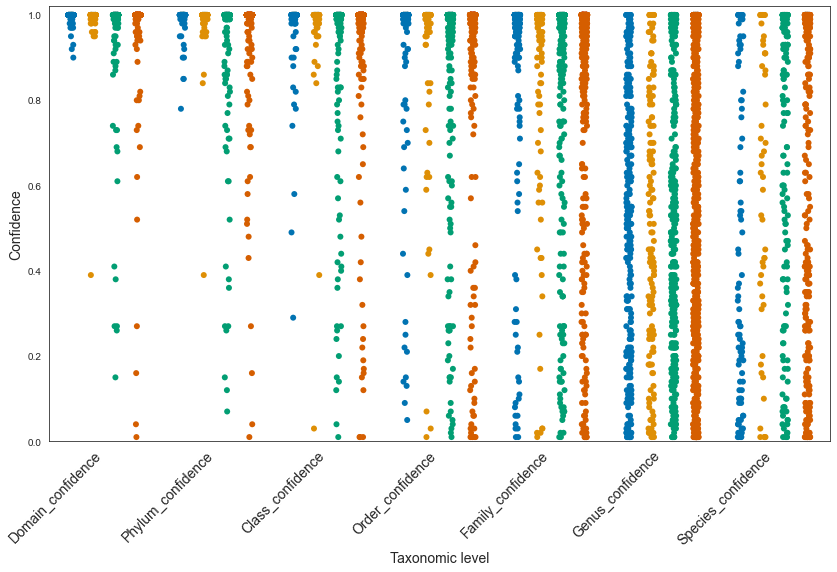

In [84]:
plt.figure(figsize=(14,8))
sns.set_style("white")
#grped_vplot = sns.violinplot(data=df_all, x="variable", y="value", hue="Source", 
            # palette="colorblind", scale='width')
scat_plot = sns.stripplot(data=df_all, x="variable", y="value", hue="Source",
                             color="k", dodge=True, palette="colorblind", size=6)
#plt.title("Assembly metrics by program")
plt.ylabel("Confidence", size=14)
plt.xlabel("Taxonomic level", size=14)
plt.xticks(rotation=45, ha='right', size=14)
plt.ylim(0, 1.02)

# Let us first get legend information from the plot object
handles, labels = scat_plot.get_legend_handles_labels()
# specify just one legend
l = plt.legend(handles[0:4], labels[0:4], prop={'size': 15})
plt.gca().get_legend().remove()

plt.savefig("SSU_SILVA_PR2_taxonomy_confidences_scatter_nolegend.svg", format='svg', dpi=1200, bbox_inches='tight')
plt.show()

## Run one-way ANOVA to test for significant differences

In [85]:
import scipy.stats as stats

### Function to prepare data for stats test

In [97]:
def format_vsearch_stats(vs, source):
    taxa = vs[['hit']].copy()
    taxa.dropna(inplace=True)
    x = max(list(taxa['hit'].str.split(',').str.len()))
    if x == 7:
        taxa[['Domain','Kingdom','Phylum','Class','Order','Family','Genus']] = taxa['hit'].str.split(",", n=7, expand=True)
    else:
        taxa[['Domain','Kingdom','Phylum','Class','Order','Family','Genus','Species']] = taxa['hit'].str.split(",", n=8, expand=True)
    taxa = taxa[taxa['Domain'].str.contains('None')==False] # filter out sequences with no assignment
    taxa = taxa.replace("\(NOR5\)", "-NOR5", regex=True)
    taxa = taxa.replace("\(Marine_group_B\)", "-Marine_Group_B", regex=True)
    taxa = taxa.replace("\(SAR406_clade\)", "-SAR406_clade", regex=True)
    taxa[['Domain','Domain_confidence']] = taxa['Domain'].str.split("(", n=2, expand=True, regex=False)
    taxa['Domain_confidence'] = taxa['Domain_confidence'].str.replace(")", "", regex=True)
    taxa[['Kingdom','Kingdom_confidence']] = taxa['Kingdom'].str.split("(", n=2, expand=True, regex=False)
    taxa['Kingdom_confidence'] = taxa['Kingdom_confidence'].str.replace(")", "", regex=True)
    taxa[['Phylum','Phylum_confidence']] = taxa['Phylum'].str.split("(", n=2, expand=True, regex=False)
    taxa['Phylum_confidence'] = taxa['Phylum_confidence'].str.replace(")", "", regex=True)
    taxa[['Class','Class_confidence']] = taxa['Class'].str.split("(", n=2, expand=True, regex=False)
    taxa['Class_confidence'] = taxa['Class_confidence'].str.replace(")", "", regex=True)
    taxa[['Order','Order_confidence']] = taxa['Order'].str.split("(", n=2, expand=True, regex=False)
    taxa['Order_confidence'] = taxa['Order_confidence'].str.replace(")", "", regex=True)
    taxa[['Family','Family_confidence']] = taxa['Family'].str.split("(", n=2, expand=True, regex=False)
    taxa['Family_confidence'] = taxa['Family_confidence'].str.replace(")", "", regex=True)
    taxa[['Genus','Genus_confidence']] = taxa['Genus'].str.split("(", n=2, expand=True, regex=False)
    taxa['Genus_confidence'] = taxa['Genus_confidence'].str.replace(")", "", regex=True)
    if x != 7:
        taxa[['Species','Species_confidence']] = taxa['Species'].str.split("(", n=2, expand=True, regex=False)
        taxa['Species_confidence'] = taxa['Species_confidence'].str.replace(")", "", regex=True)
        conf = taxa[['Domain_confidence','Kingdom_confidence','Phylum_confidence','Class_confidence','Order_confidence','Family_confidence',
             'Genus_confidence','Species_confidence']]
    else:
        conf = taxa[['Domain_confidence','Kingdom_confidence','Phylum_confidence','Class_confidence','Order_confidence','Family_confidence',
             'Genus_confidence']]
    conf = conf.astype(float)
    conf = conf.rename({'hit': source})
    conf = conf.add_prefix('%s_' % source)
    conf = conf.reset_index().drop(columns='index')
    return(conf)

In [98]:
df=[]

for tsv in glob.glob("*.tsv"):
    a, b, c, d = tsv.split('_', maxsplit=3)
    vsearch = pd.read_csv(tsv, sep=" |\t", header=None, names=['query', 'hit','strand'], engine='python')
    vsearch_formatted = format_vsearch_stats(vsearch, a)
    df.append(vsearch_formatted)
    
df_all = pd.concat(df, axis=1, join="inner")

In [99]:
df_all.head()

,1903c122_Domain_confidence,1903c122_Kingdom_confidence,1903c122_Phylum_confidence,1903c122_Class_confidence,1903c122_Order_confidence,1903c122_Family_confidence,1903c122_Genus_confidence,1903c122_Species_confidence,1903c126_Domain_confidence,1903c126_Kingdom_confidence,...,1903c117_Genus_confidence,1903c117_Species_confidence,1903c127_Domain_confidence,1903c127_Kingdom_confidence,1903c127_Phylum_confidence,1903c127_Class_confidence,1903c127_Order_confidence,1903c127_Family_confidence,1903c127_Genus_confidence,1903c127_Species_confidence
0,1.0,1.0,1.0,1.0,1.0,1.0,0.25,NaN,1.0,1.0,...,1.00,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0.99,NaN
1,1.0,1.0,1.0,1.0,1.0,1.0,0.53,NaN,1.0,1.0,...,0.76,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0.27,NaN


In [100]:
df_level = df_all.filter(regex='Species')
print(list(df_level.columns))

['1903c122_Species_confidence', '1903c126_Species_confidence', '1903c126_Species_confidence', 'Las19c107_Species_confidence', '1903c122_Species_confidence', '1903c119_Species_confidence', '1903c123_Species_confidence', '1903c119_Species_confidence', '1903c144_Species_confidence', 'Las19c138_Species_confidence', '1903c123_Species_confidence', '1903c124_Species_confidence', '1903c123_Species_confidence', '1903c126_Species_confidence', 'Las19c138_Species_confidence', '1903c122_Species_confidence', '1903c122_Species_confidence', '1903c126_Species_confidence', '1903c144_Species_confidence', '1903c119_Species_confidence', '1903c123_Species_confidence', '1903c123_Species_confidence', 'Las19c138_Species_confidence', '1903c111_Species_confidence', '1903c111_Species_confidence', '1903c124_Species_confidence', 'Las19c107_Species_confidence', '1903c129_Species_confidence', '1903c129_Species_confidence', 'Las19c107_Species_confidence', '1903c124_Species_confidence', '1903c111_Species_confidence', '

## Run ANOVA to test for differences

In [101]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(df_level.loc[:, df_level.columns.str.match('^SPAdes')], 
                                df_level.loc[:, df_level.columns.str.match('^Ill-PF')], 
                                df_level.loc[:, df_level.columns.str.match('^hybrid')], 
                                df_level.loc[:, df_level.columns.str.match('^metaFlye')])
print(fvalue, pvalue)

[] []


#### We know that group values are statistically significantly different, but ANOVA does not tell which groups are significantly different from which other groups. To know the pairs of significant different treatments, we will perform multiple pairwise comparison (post hoc comparison) analysis for all unplanned comparison using Tukey’s honestly significantly differenced (HSD) test.

In [20]:
from bioinfokit.analys import stat
# perform multiple pairwise comparison (Tukey's HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test

In [36]:
df_melt = pd.melt(df_level.reset_index(), id_vars=['index'], value_vars=list(df_level))
df_melt.head()

,index,variable,value
0,0,Illumina_SPAdes_Species_confidence,0.07
1,1,Illumina_SPAdes_Species_confidence,0.16
2,2,Illumina_SPAdes_Species_confidence,0.31
3,3,Illumina_SPAdes_Species_confidence,0.22
4,4,Illumina_SPAdes_Species_confidence,0.39


In [37]:
res = stat()
res.tukey_hsd(df=df_melt, res_var='value', xfac_var='variable', anova_model='value ~ C(variable)')
res.tukey_summary

/Users/nastassia.patin/miniconda3/lib/python3.8/site-packages/bioinfokit/analys.py:402: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Illumina_SPAdes_Species_confidence,hybridSPAdes_Species_confidence,0.090439,-0.010003,0.190880,3.283618,0.094514
1,Illumina_SPAdes_Species_confidence,metaflye_Species_confidence,0.071930,-0.028512,0.172371,2.611607,0.252981
2,Illumina_SPAdes_Species_confidence,Illumina_pf_Species_confidence,0.032105,-0.068336,0.132547,1.165669,0.822678
3,hybridSPAdes_Species_confidence,metaflye_Species_confidence,0.018509,-0.081933,0.118950,0.672011,0.900000
4,hybridSPAdes_Species_confidence,Illumina_pf_Species_confidence,0.058333,-0.042108,0.158775,2.117950,0.441209
5,metaflye_Species_confidence,Illumina_pf_Species_confidence,0.039825,-0.060617,0.140266,1.445939,0.711566


In [ ]:
# Note: p-value 0.001 from tukey_hsd output should be interpreted as <=0.001

In [38]:
res.tukey_summary.to_csv("Species_differences_HSD.csv", index=None)